## Test for functionality of inverse convariance routine with gpu-zeropad code

Also comparison to corrcal algo of determinant correctness.

##### Module imports

In [1]:
import numpy as np
import cupy as cp
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))
from zp_puregpu_funcs_py import *
from invcov import *

hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.
hello world


##### Simulation parameters. ie. noise, diffuse, and source matrices with correct matrix shapes + edges array.

In [32]:
#the main parametes describing our problem.
n_bl = 50
n_eig = 3
n_src = 6
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 10))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
# sim_noise_mat = xp.where(sim_noise_mat == 0, 0.1, sim_noise_mat)
sim_noise_mat = sim_noise_mat.reshape(len(sim_noise_mat), 1)
print(sim_noise_mat.shape)
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')

The edges of the redundant blocks have indices[ 0  4  6 14 19 20 24 35 43 50]
(50, 1)


##### We zeropad the matrices first, then return the inverse covariance

In [33]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue 
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

#Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
sim_noise_mat_2d = zp_sim_noise_mat.reshape(n_blocks, largest_block)
sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)


In [34]:
print(sim_noise_mat.shape)
print(sim_diff_mat.shape)
print(sim_src_mat.shape)

(50, 1)
(50, 3)
(50, 6)


In [35]:
#find inverse components
logdet, N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges=edges, xp = xp , ret_det = True, N_is_inv=True)

(9, 11, 3)
(9, 11, 3)


In [46]:
print(logdet)

451.99319185169355


In [36]:
print(N_inv.shape)
print(Del_p.shape)
print(Sig_p.shape)

(9, 11)
(9, 11, 3)
(9, 11, 6)


In [37]:
N_inv = N_inv.reshape(n_blocks*largest_block)
Del_p = Del_p.reshape(n_blocks*largest_block, n_eig)
Sig_p = Sig_p.reshape(n_blocks*largest_block, n_src)

In [38]:
#convert sparse things to dense things to visualize what we're really working with
sim_diff_mat_dense = sparden_convert(sim_diff_mat, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp)
Del_p_dense = sparden_convert(Del_p, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp)

##### At this point, we are set up to visualize the dense version of the diffuse matrix

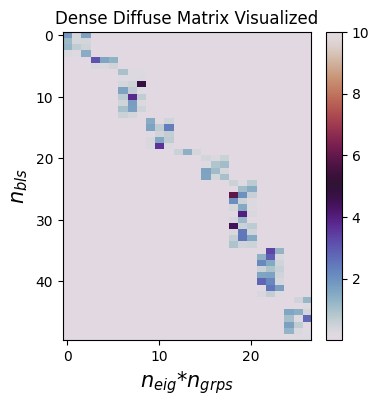

In [44]:
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(cp.log(sim_diff_mat_dense + 1e-20)*-1), vmax = 10, cmap='twilight', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

#would like the center to be at 0, vmin and vmax only differ by a sign

In [45]:
#First we assemble te dense covariance object using the input matrices above
C = xp.diag(sim_noise_mat) + sim_diff_mat_dense@sim_diff_mat_dense.T + sim_src_mat@sim_src_mat.T

#Now we do the same with the inverse covariance components
C_inv = xp.diag(N_inv) - Del_p_dense@Del_p_dense.T - Sig_p@Sig_p.T

#now check their matrix product returns the identity
if np.allclose(C@C_inv, np.eye(C.shape[0])) == True:
    print("C*C^{-1} returns the identity")

#brute force computation of C^{-1} using numpy
C_numpy_inv = cp.linalg.inv(C)

#check the answer is the same as C = N + Del * Del^dag + Sig * Sig^dag 
if np.allclose(C_inv, C_numpy_inv) == True:
    print("Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine")


ValueError: operands could not be broadcast together with shapes (99, 99) (50, 50)